In this notebook, we will use an LSTM to perform a forecast on a time series, using [this data set](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data) from Kaggle.

In [ ]:
!wget http://mg.bluecourses.com/wp-content/uploads/2020/04/competitive-data-science-predict-future-sales.zip -O sales.zip

--2020-07-21 11:37:18--  http://mg.bluecourses.com/wp-content/uploads/2020/04/competitive-data-science-predict-future-sales.zip
Resolving mg.bluecourses.com (mg.bluecourses.com)... 46.30.215.75
Connecting to mg.bluecourses.com (mg.bluecourses.com)|46.30.215.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15845085 (15M) [application/zip]
Saving to: ‘sales.zip’

sales.zip           100%[===================>]  15.11M   281KB/s    in 21s     

2020-07-21 11:37:40 (740 KB/s) - ‘sales.zip’ saved [15845085/15845085]



In [ ]:
!unzip sales.zip

Archive:  sales.zip
  inflating: item_categories.csv     
  inflating: items.csv               
  inflating: sales_train.csv         
  inflating: sample_submission.csv   
  inflating: shops.csv               
  inflating: test.csv                


In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import sequence
from matplotlib import pyplot as plt
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

Load in the data set:

In [ ]:
data = pd.read_csv('sales_train.csv')
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


There are multiple shops and items in the data set. A nice extension for this example is to train a network that can take this information into account and predict per shop and item, but we're going to focus on a single item only:

In [ ]:
data.groupby('item_id').count().sort_values(by='date', ascending=False).head()

,date,date_block_num,shop_id,item_price,item_cnt_day
item_id,,,,,
20949,31340,31340,31340,31340,31340
5822,9408,9408,9408,9408,9408
17717,9067,9067,9067,9067,9067
2808,7479,7479,7479,7479,7479
4181,6853,6853,6853,6853,6853


Item "20949" appears the most, so we're going to keep that one only and sum the sales per date over the shops:

In [ ]:
data_processed         = data.loc[data.item_id == 20949, ['date', 'item_cnt_day']].groupby('date').sum()
data_processed.index   = pd.to_datetime(data_processed.index)
data_processed.sort_index(inplace=True)
data_processed.head()

,item_cnt_day
date,
2013-01-05,115.0
2013-01-06,397.0
2013-01-07,224.0
2013-01-08,191.0
2013-01-09,324.0


We also make sure all days are present:

In [ ]:
new_index              = pd.date_range(data_processed.index.min(), data_processed.index.max())
data_processed         = data_processed.reindex(new_index, fill_value=0)
data_processed['date'] = data_processed.index
data_processed.head(20)

,item_cnt_day,date
2013-01-05,115.0,2013-01-05
2013-01-06,397.0,2013-01-06
2013-01-07,224.0,2013-01-07
2013-01-08,191.0,2013-01-08
2013-01-09,324.0,2013-01-09
2013-01-10,211.0,2013-01-10
2013-01-11,316.0,2013-01-11
2013-01-12,351.0,2013-01-12
2013-01-13,0.0,2013-01-13
2013-01-14,0.0,2013-01-14


And finally, we'll group by week:

In [ ]:
data_processed_weekly = data_processed.groupby(pd.Grouper(key='date', freq='W-MON'))['item_cnt_day'].sum().reset_index()
data_processed_weekly.set_index('date', inplace=True)
data_processed_weekly.head()

,item_cnt_day
date,
2013-01-07,736.0
2013-01-14,1393.0
2013-01-21,0.0
2013-01-28,0.0
2013-02-04,0.0


Let's show the time series:

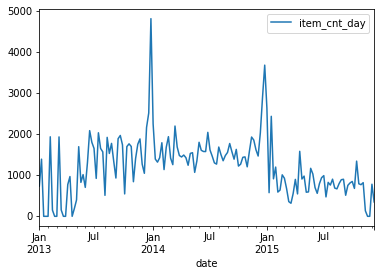

In [ ]:
data_processed_weekly.plot()

We're going to construct an LSTM that predicts a week ahead given the last eight weeks of data.

First, we will define a couple of functions to prepare the data set to feed it to the network:

In [ ]:
def select_between(data, fr, to):
  return data.loc[(data.index > np.datetime64(fr)) & (data.index <= np.datetime64(to)), :]

def prepare_instances(data, look_before=8, predict_ahead=1):
  TS = []; X  = []; Y  = []
  for anchor in data.index:
    before = select_between(data, anchor - timedelta(weeks=look_before), anchor).values
    after  = select_between(data, anchor, anchor + timedelta(weeks=predict_ahead)).values
    TS.append(anchor); X.append(before.flatten()); Y.append(after.flatten())
  return np.array(TS), \
    sequence.pad_sequences(np.array(X), look_before), \
    sequence.pad_sequences(np.array(Y), predict_ahead, padding='post')

In [ ]:
TS, X, Y = prepare_instances(data_processed_weekly)

In [ ]:
# Example:
print(TS[10])
print(X[10])
print(Y[10])

2013-03-18 00:00:00
[   0    0 1938  151    0    0 1935  155]
[0]


In [ ]:
TS.shape, X.shape, Y.shape

((154,), (154, 8), (154, 1))

We can now define our LSTM:

In [ ]:
model = Sequential()

model.add(LSTM(16, input_shape=(X.shape[1], 1)))
model.add(Dense(Y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


We're ready to train our model. We'll split the data set based on the first week after 1st of Jan. 2015 for training and testing.

In [ ]:
train_test_split_point = np.where(TS >= date(2015, 1, 1))[0][0]
train_test_split_point

104

It is crucial that we normalize our data. To do so, we apply a MinMaxScaler on the Y values in the training set, and apply it on X and Y:

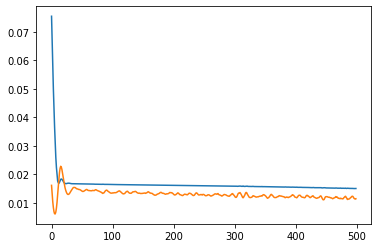

In [ ]:
scaler = MinMaxScaler().fit(Y[:train_test_split_point])
X_scaled = np.expand_dims(scaler.transform(X), axis=-1)
Y_scaled = scaler.transform(Y)

hist = model.fit(X_scaled[:train_test_split_point], Y_scaled[:train_test_split_point], 
                 epochs=500, batch_size=64, verbose=0, 
                 validation_data=(X_scaled[train_test_split_point:], Y_scaled[train_test_split_point:])
)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

We can now plot our predictions. Don't forget to unscale the predictions:

In [ ]:
predictions = scaler.inverse_transform(model.predict(X_scaled))

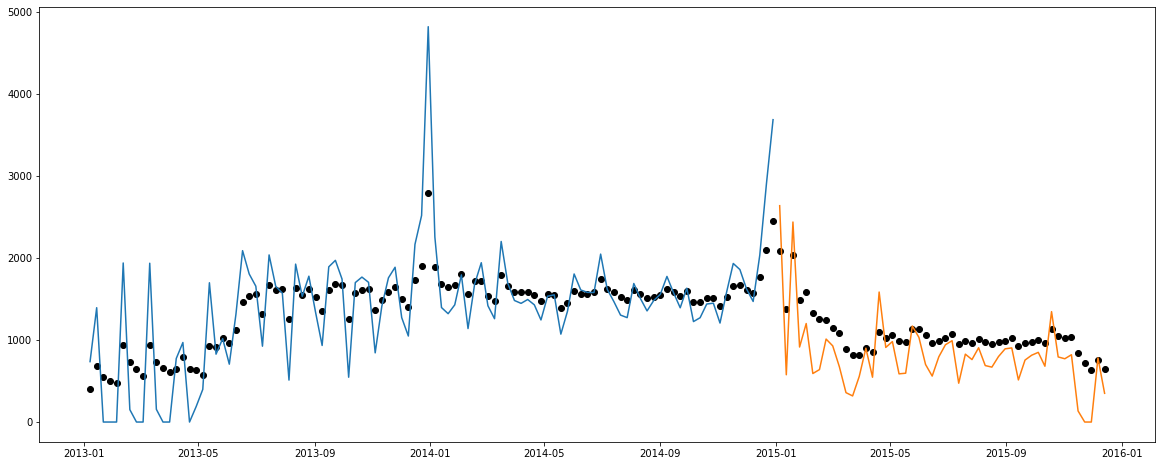

In [ ]:
givens_train = [X[idx][-1] for idx, anchor in enumerate(TS) if idx <   train_test_split_point ]
givens_test  = [X[idx][-1] for idx, anchor in enumerate(TS) if idx >=  train_test_split_point ]

plt.subplots(figsize=(20,8))
plt.plot(TS[:train_test_split_point], givens_train)
plt.plot(TS[train_test_split_point:], givens_test)

for idx, anchor in enumerate(TS):
  p = predictions[idx]
  plt.scatter(TS[idx: idx+len(p)], p, c='black')

Things to try:

- Try this approach using a [bidirectional LSTM](https://keras.io/layers/wrappers/).
- You can also try stacking multiple LSTM layers on top of each other.
- Play around with the amount of weeks used.
- Try to modify this network to predict multiple weeks ahead.
- Research how the `stateful` parameter works for an LSTM. Setting this to true would allow us to feed the whole sequence to the network instead of having to split it up in batches ourselves, but would require us to manually call `reset_state`. [This link](https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/) is a good resource to start with.